# Description

The purpose of this work is to get acquainted with the architecture of GoogLeNet.

# Tasks

In [1]:
import time
import numpy as np

import torch
from torch import nn
import torchvision
from torchvision.models import resnet18, googlenet

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Task 1. Implement the architecture of the GoogLeNet.

In [2]:
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        
        # 1x1 conv branch
        self.b1 = nn.Sequential(nn.Conv2d(in_planes, n1x1, kernel_size=1), 
                                nn.BatchNorm2d(n1x1), 
                                nn.ReLU(True))
        
        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(nn.Conv2d(in_planes, n3x3red, kernel_size=1),
                                nn.BatchNorm2d(n3x3red), nn.ReLU(True),
                                nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1), 
                                nn.BatchNorm2d(n3x3),
                                nn.ReLU(True))
        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(nn.Conv2d(in_planes, n5x5red, kernel_size=1),
                                nn.BatchNorm2d(n5x5red),
                                nn.ReLU(True),
                                nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
                                nn.BatchNorm2d(n5x5),
                                nn.ReLU(True),
                                nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
                                nn.BatchNorm2d(n5x5),
                                nn.ReLU(True))
        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(nn.MaxPool2d(3, stride=1, padding=1),
                                nn.Conv2d(in_planes, pool_planes, kernel_size=1),
                                nn.BatchNorm2d(pool_planes),
                                nn.ReLU(True))
        
    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)

In [3]:
class InceptionAux(nn.Module):
    def __init__(self, in_planes, num_classes):
        super(InceptionAux, self).__init__()
        
        self.conv = nn.Conv2d(in_planes, 128, kernel_size=1)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        # aux1: N x 512 x 14 x 14, aux2: N x 528 x 14 x 14
        x = torch.nn.functional.adaptive_avg_pool2d(x, (4, 4))
        # aux1: N x 512 x 4 x 4, aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = torch.flatten(x, 1)
        # N x 2048
        x = torch.nn.functional.relu(self.fc1(x), inplace=True)
        # N x 1024
        x = torch.nn.functional.dropout(x, 0.7, training=self.training)
        # N x 1024
        x = self.fc2(x)
        # N x 1000 (num_classes)
        return x

In [4]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=1000, aux_logits=True):
        super(GoogLeNet, self).__init__()
        
        self.pre_layers = nn.Sequential(
            # N x 3 x 224 x 224
            nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2),
            # N x 64 x 112 x 112
            nn.MaxPool2d(3, stride=2, ceil_mode=True),
            # N x 64 x 56 x 56
            nn.Conv2d(64, 64, kernel_size=1),
            # N x 64 x 56 x 56
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            # N x 192 x 56 x 56
            nn.MaxPool2d(3, stride=2, ceil_mode=True),
            # N x 192 x 28 x 28
            # Or just use one conv layer
            # nn.Conv2d(3, 192, kernel_size=3, padding=1),
            # nn.BatchNorm2d(192),
            # nn.ReLU(True)
            )
        
        self.aux_logits = aux_logits
        
        self.a3 = Inception(192, 64, 96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)
        
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        
        self.a4 = Inception(480, 192, 96, 208, 16, 48, 64)
        self.b4 = Inception(512, 160, 112, 224, 24, 64, 64)
        self.c4 = Inception(512, 128, 128, 256, 24, 64, 64)
        self.d4 = Inception(512, 112, 144, 288, 32, 64, 64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)
        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)
        
        if aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)

        # self.avgpool = nn.AvgPool2d(8, stride=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(1024, num_classes)

    def forward(self, x):
        # N x 3 x 224 x 224
        out = self.pre_layers(x)
        # N x 192 x 28 x 28
        out = self.a3(out)
        # N x 256 x 28 x 28
        out = self.b3(out)
        # N x 480 x 28 x 28
        out = self.maxpool(out)
        # N x 480 x 14 x 14
        out = self.a4(out)
        # N x 512 x 14 x 14
        aux_defined = self.training and self.aux_logits
        
        if aux_defined:
            aux1 = self.aux1(out)
        else:
            aux1 = None

        out = self.b4(out)
        # N x 512 x 14 x 14
        out = self.c4(out)
        # N x 512 x 14 x 14
        out = self.d4(out)
        # N x 528 x 14 x 14

        if aux_defined:
            aux2 = self.aux2(out)
        else:
            aux2 = None

        out = self.e4(out)
        # N x 832 x 14 x 14
        out = self.maxpool(out)
        # N x 832 x 7 x 7
        out = self.a5(out)
        # N x 832 x 7 x 7
        out = self.b5(out)
        # N x 1024 x 7 x 7
        out = self.avgpool(out)
        # N x 1024 x 1 x 1
        out = out.view(out.size(0), -1) # or use x = torch.flatten(x, 1)
        # N x 1024
        x = self.dropout(x)
        out = self.linear(out)
        # N x 1000 (num_classes)

        if aux_defined:
            return out, aux2, aux1
        else:
            return out

Task 2. Compare the implemented GoogLeNet architecture with the build-in GoogLeNet architecture and ResNet architecture. 

__Data preparation__

In [5]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [6]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [7]:
X_train /= 255.
X_test /= 255.

tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

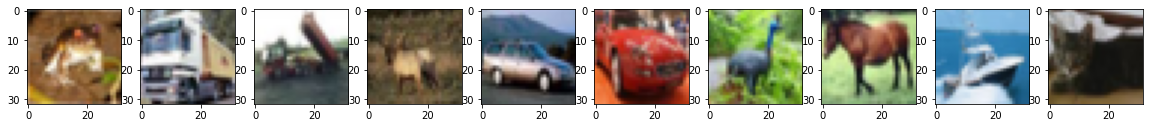

In [8]:
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')

In [9]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

__Training process__

In [10]:
def train(net, X_train, y_train, X_test, y_test, batch_size=256, epoch_num=50, epoch_info_show=10,
          weight_decay=0, save_net_state=False, verbose=True):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3, weight_decay=weight_decay)

    t = time.time()
    test_accuracy_history = []
    test_loss_history = []
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(1, epoch_num+1):
        order = np.random.permutation(len(X_train))

        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()
            
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)
            
            if net.__class__.__name__ == "GoogLeNet" and net.aux_logits:
                preds = net.forward(X_batch)
                loss_value1 = loss(preds[0], y_batch)
                loss_value2 = loss(preds[1], y_batch)
                loss_value3 = loss(preds[2], y_batch)
                loss_value = loss_value1 + 0.3 * loss_value2 + 0.3 * loss_value3
            else:
                preds = net.forward(X_batch)
                loss_value = loss(preds, y_batch)
            
            loss_value.backward()

            optimizer.step()
      
        net.eval()
        with torch.no_grad():
            test_preds = net.forward(X_test)
            loss_value = loss(test_preds, y_test).item()
            test_loss_history.append(loss_value)

            accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()
            test_accuracy_history.append(accuracy)
        
            if verbose:
                if epoch % epoch_info_show == 0:
                    if device.type == 'cuda':
                            print('Train Epoch: {} Time: {} Accuracy: {}, GPU_Mem_alloc: {} GPU_Mem_cashed: {}'.format(
                            epoch, time.strftime("%H:%M:%S", time.gmtime(time.time() - t)), 
                            accuracy, torch.cuda.memory_allocated(),torch.cuda.memory_cached()))      
                    else:
                        print('Train Epoch: {} Time: {} Accuracy: {}'.format(epoch, 
                            time.strftime("%H:%M:%S", time.gmtime(time.time() - t)), accuracy))

    net_state = net.state_dict()
    del net

    if save_net_state:
        return test_accuracy_history, test_loss_history, net_state
    else:
        return test_accuracy_history, test_loss_history

In [11]:
# add two dicts for saving information about models work
accuracies = {}
losses = {}

__Plotting graphs__

In [12]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(15, 6)})

def acc_loss_graph(accuracies, losses, net_list, save_file_name='plot.png', download=False):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    for experiment_id in net_list:
        ax1.plot(accuracies[experiment_id], label=experiment_id)
    
    ax1.legend()
    ax1.set_title('Validation Accuracy')
    fig.tight_layout()

    for experiment_id in net_list:
        ax2.plot(losses[experiment_id], label=experiment_id)
    
    ax2.legend()
    ax2.set_title('Validation Loss');

    fig.tight_layout()
    
    if download:
        fig.savefig(save_file_name)

__Training models__

In [13]:
# Training implemented GoogLeNet model 
accuracies['implemented_GoogLeNet'], losses['implemented_GoogLeNet'] = train(GoogLeNet(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:08:57 Accuracy: 0.7350999712944031, GPU_Mem_alloc: 388824576 GPU_Mem_cashed: 5909774336
Train Epoch: 20 Time: 00:17:53 Accuracy: 0.7274999618530273, GPU_Mem_alloc: 388824576 GPU_Mem_cashed: 5909774336
Train Epoch: 30 Time: 00:26:49 Accuracy: 0.7443999648094177, GPU_Mem_alloc: 388824576 GPU_Mem_cashed: 5909774336
Train Epoch: 40 Time: 00:35:46 Accuracy: 0.7581999897956848, GPU_Mem_alloc: 388824576 GPU_Mem_cashed: 5909774336
Train Epoch: 50 Time: 00:44:42 Accuracy: 0.7548999786376953, GPU_Mem_alloc: 388824576 GPU_Mem_cashed: 5909774336


In [14]:
# Training build-in GoogLeNet model
accuracies['build-in_GoogLeNet'], losses['build-in_GoogLeNet'] = train(googlenet(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:07:36 Accuracy: 0.7563999891281128, GPU_Mem_alloc: 378079744 GPU_Mem_cashed: 10334765056
Train Epoch: 20 Time: 00:15:14 Accuracy: 0.777999997138977, GPU_Mem_alloc: 378079744 GPU_Mem_cashed: 10334765056
Train Epoch: 30 Time: 00:22:49 Accuracy: 0.7793999910354614, GPU_Mem_alloc: 378079744 GPU_Mem_cashed: 10334765056
Train Epoch: 40 Time: 00:30:25 Accuracy: 0.7910000085830688, GPU_Mem_alloc: 378079744 GPU_Mem_cashed: 10334765056
Train Epoch: 50 Time: 00:38:00 Accuracy: 0.7516999840736389, GPU_Mem_alloc: 378079744 GPU_Mem_cashed: 10334765056


In [15]:
# Training ResNet18 model
accuracies['ResNet18'], losses['ResNet18'] = train(resnet18(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:03:45 Accuracy: 0.6840999722480774, GPU_Mem_alloc: 354193920 GPU_Mem_cashed: 10334765056
Train Epoch: 20 Time: 00:07:30 Accuracy: 0.7260000109672546, GPU_Mem_alloc: 354193920 GPU_Mem_cashed: 10334765056
Train Epoch: 30 Time: 00:11:15 Accuracy: 0.7317999601364136, GPU_Mem_alloc: 354193920 GPU_Mem_cashed: 10334765056
Train Epoch: 40 Time: 00:15:01 Accuracy: 0.7269999980926514, GPU_Mem_alloc: 354193920 GPU_Mem_cashed: 10334765056
Train Epoch: 50 Time: 00:18:46 Accuracy: 0.73499995470047, GPU_Mem_alloc: 354193920 GPU_Mem_cashed: 10334765056


__Visualization of training__

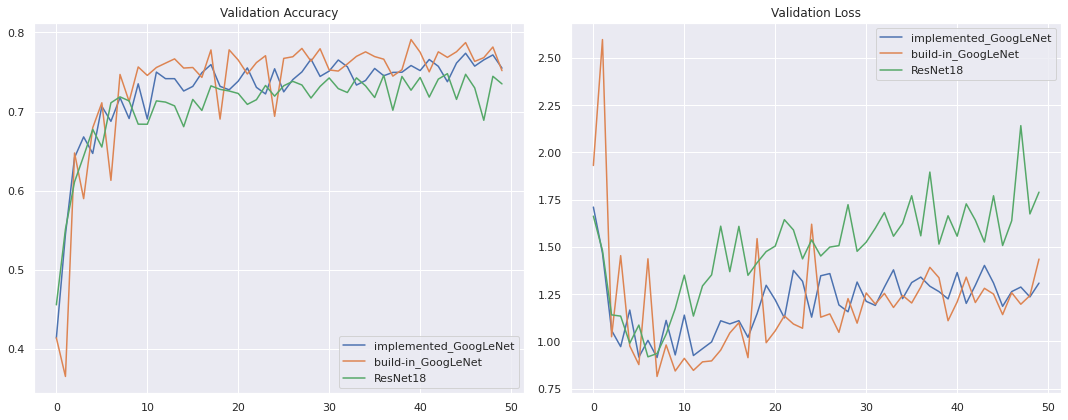

In [16]:
acc_loss_graph(accuracies, losses, ['implemented_GoogLeNet', 'build-in_GoogLeNet', 'ResNet18'])